以下のサイトを利用した

https://dreamer-uma.com/mcmc-ising/

In [1]:
import os
import numpy as np
import random
import scipy as sp
import pickle
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
class LatticeIsing_2D():
    def __init__(self, N, J, h):
        """
        Attributes:
            N: 格子サイズ
            J: 相互作用
            h: 磁場
        """
        self.N=N
        self.J=J
        self.h=h
    
    def neighor_spin_sum(self, state, x, y):

        center_spin = state[y, x]
        right, left, up, down=x+1, x-1, y+1, y-1

        # 周期境界条件
        if right>=self.N:
            right_spin=state[y, 0]
        else:
            right_spin=state[y, right]
            
        if left<0:
            left=self.N-1
            left_spin=state[y, left]
        else:
            left_spin=state[y, left]
            
        if down<0:
            down=self.N-1
            down_spin=state[down, x]
        else:
            down_spin=state[down, x]
    
        if up>=self.N:
            up_spin=state[0, x]
        else:
            up_spin=state[up, x]
            
        neighor_spin_sum=self.J * center_spin * (right_spin+left_spin+up_spin+down_spin)
        return neighor_spin_sum

    # エネルギーを計算
    def energy(self, state):
        energy=0
        for x in range(self.N):
            for y in range(self.N):
                energy -= self.neighor_spin_sum(state, x, y)/2
        energy -= self.h*np.sum(state)
        return energy
    
    # 磁化を計算
    def magnetization(self, state):
        return np.mean(state)

マルコフ連鎖モンテカルロ法

・gibbsサンプリングのコードが間違っているかも

In [3]:
state_dynamics=np.zeros((3, 4, 4))
print(state_dynamics)

state_dynamics[0]

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]


array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [4]:
# flip_order_x = list(range(dist.N))
#         flip_order_y = list(range(dist.N))
#         random.shuffle(flip_order_x)
#         random.shuffle(flip_order_y)
        
flip_order_x = list(range(10))
print(flip_order_x)

random.shuffle(flip_order_x)
print(flip_order_x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[3, 1, 4, 0, 7, 6, 9, 5, 8, 2]


In [5]:
l = [0, 1, 2, 3, 4]

random.shuffle(l)
print(l)
# [0, 3, 2, 4, 1]

[4, 1, 2, 0, 3]


In [6]:
class IsingMC():
    def __init__(self, method):
        self.method=method

    def run_mcmc(self, dist, init_state, beta, n_step):
        
        state=init_state
        state_dynamics=np.zeros((n_step+1, dist.N, dist.N))
        state_dynamics[0]=state
        AR_dynamics=[]

        for step in range(n_step):
            if self.method=="gibbs":
                state, AR = self.step_Gibbs(dist, state, beta)
            else:
                state, AR = self.step_MH(dist, state, beta)
            
            AR_dynamics.append(AR)
            state_dynamics[step+1] = state
        # print(f'ACCEPTANCE RATE : {np.mean(AR_dynamics):.3f}')
        return state_dynamics, AR_dynamics    
    
    # モンテカルロ法
    def step_MH(self, dist, state, beta):
        # select rule
        # flip_order_x = list(range(dist.N))
        # flip_order_y = list(range(dist.N))
        # random.shuffle(flip_order_x)
        # random.shuffle(flip_order_y)
        
        # n_flg = 0
        # for y in flip_order_y:
        #     for x in flip_order_x:
        #         delta_energy = 2 * (dist.neighor_spin_sum(state, x, y) + dist.h * state[y, x])
        #         trans_prob = np.exp(-beta * delta_energy)
        #         if delta_energy < 0:
        #             state[y, x] *= -1
        #             n_flg += 1
        #         elif np.random.random() <= trans_prob:
        #             state[y, x] *= -1
        #             n_flg += 1
        # return state, n_flg / (dist.N * dist.N)     # 2つ目のは反転率?

        n_flg = 0
        for i in range(dist.N * dist.N):
            x = np.random.randint(dist.N)
            y = np.random.randint(dist.N)
            delta_energy = 2 * (dist.neighor_spin_sum(state, x, y) + dist.h * state[y, x])
            trans_prob = np.exp(-beta * delta_energy)
            if delta_energy < 0:
                state[y, x] *= -1
                n_flg += 1
            elif np.random.random() <= trans_prob:
                state[y, x] *= -1
                n_flg += 1
        return state, n_flg / (dist.N * dist.N)     # 2つ目のは反転率?

    # ギブスサンプリング
    def step_Gibbs(self, dist, state, beta):
        # select rule
        flip_order_x = list(range(dist.N))
        flip_order_y = list(range(dist.N))
        random.shuffle(flip_order_x)
        random.shuffle(flip_order_y)
        for x in flip_order_x:
            for y in flip_order_y:
                neighors = (dist.neighor_spin_sum(state, x, y)+dist.h*state[y, x])/state[y, x]
                trans_prob = np.exp(beta*neighors)/(np.exp(beta*neighors)+np.exp(-beta*neighors))
                if np.random.random()<=trans_prob:
                    state[y, x] *=1
                else:
                    state[y, x] *=-1
        return state, 1.0

In [7]:
# # 磁化が負の場合にスピン全体を反転する関数
# def reverse(Spin):
#     Magnetization = Spin.sum()
#     if Magnetization < 0:
#         Spin = -Spin
#     return Spin

In [8]:
# # Ising Instance
# N = 32
# h = 0.0
# J = 1
# dist=LatticeIsing_2D(N, J, h)
# # MCMC Instance
# beta = 80
# n_step = 300
# init_state = np.random.choice([-1,1], size=(dist.N,dist.N))
# sampler=IsingMC(method="metropolis")
# state_dynamics, AR_dynamics = sampler.run_mcmc(dist, init_state, beta, n_step)
# print(state_dynamics[300])

In [9]:
# spin_data = []  
# label_data = []
# # Ising Instance
# N = 8
# h = 0.0
# J = 1
# dist=LatticeIsing_2D(N, J, h)
# # MCMC Instance
# n_step = 300
# sampler=IsingMC(method="metropolis")

# num_label = 5
# number = 10
# for i in tqdm(range(num_label)):  # 0から100までを100等分で回す
#     beta = 0.2 + (i / (num_label-1)) * 0.8   
#     # 各逆温度で1000個ずつ配位を作成   
#     for j in range(number):
#         init_state = np.random.choice([-1,1], size=(dist.N,dist.N))
#         state_dynamics, _ = sampler.run_mcmc(dist, init_state, beta, n_step)
        
#         spin_data.append(state_dynamics[n_step])
#         label_data.append(beta)

In [10]:
spin_data = []  
label_data = []
# Ising Instance
N = 8
h = 0.0
J = 1
dist=LatticeIsing_2D(N, J, h)
# MCMC Instance
n_step_first = 1000     # 1つ目の配位生成
n_step_second = 50     # 2つ目以降の配位生成
sampler=IsingMC(method="metropolis")

num_label = 25     # ラベルの数
number = 1000       # 1つの逆温度ラベルに対するスピンデータの数 
for i in tqdm(range(num_label)):  # 0から100までを100等分で回す
    beta = 0.2 + (i / (num_label-1)) * 0.8   
    init_state = np.random.choice([-1,1], size=(dist.N,dist.N))
    state_dynamics, _ = sampler.run_mcmc(dist, init_state, beta, n_step=n_step_first)
    # 各逆温度で1000個ずつ配位を作成   
    for j in range(number):
        init_state = state_dynamics[n_step_first]
        state_synamics, _ = sampler.run_mcmc(dist, init_state, beta, n_step=n_step_second)
        Ising_state = state_synamics[n_step_second]
        magnetization = Ising_state.sum()
        if magnetization < 0:
            Ising_state *= -1
        spin_data.append(Ising_state)
        label_data.append(beta)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [10:32<00:00, 25.31s/it]


In [11]:
len(spin_data), len(label_data)

(25000, 25000)

In [12]:
spin_data[2480]

array([[ 1.,  1.,  1.,  1., -1., -1.,  1.,  1.],
       [-1., -1.,  1., -1., -1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1.,  1.,  1., -1., -1.],
       [-1.,  1.,  1.,  1.,  1.,  1.,  1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1., -1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [13]:
len(spin_data)

25000

データ読み込み

In [14]:
# 保存するデータをtupleにまとめる
data_to_save = (spin_data, label_data)

# フォルダ名とファイル名を指定
folder_name = "data_storage"
file_name = 'Isig_data_L8_.pkl'

# データをバイナリ形式で保存
file_path = os.path.join(folder_name, file_name)
with open(file_path, 'wb') as file:
    pickle.dump(data_to_save, file)

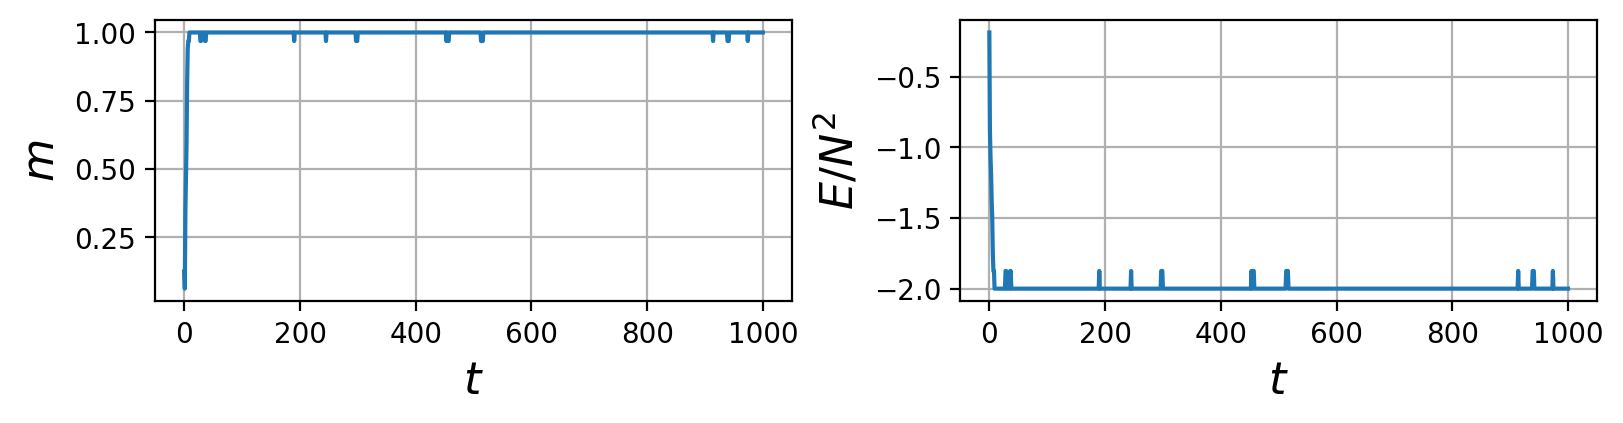

In [15]:
m_dynamics = np.array([dist.magnetization(state) for state in state_dynamics])
energy_dynamics = np.array([dist.energy(state)/(dist.N*dist.N) for state in state_dynamics])

fig, axes=plt.subplots(1, 2, figsize=(8, 2), constrained_layout=True, dpi=200)
axes[0].plot(m_dynamics)
axes[0].set_xlabel(r"$t$", fontsize=16)
axes[0].set_ylabel(r"$m$", fontsize=16)
axes[0].grid()
axes[1].plot(energy_dynamics)
axes[1].set_ylabel(r"$E/N^2$", fontsize=16)
axes[1].set_xlabel(r"$t$", fontsize=16)
axes[1].grid()
plt.show()

In [16]:
# Ising Instance
N = 64
h = 0.0
J = 1
dist=LatticeIsing_2D(N, J, h)
beta = 0.2
n_step = 1000
# MCMC Instance
init_state = np.random.choice([-1,1], size=(dist.N,dist.N))
sampler=IsingMC(method="metropolis")
state_dynamics, AR_dynamics = sampler.run_mcmc(dist, init_state, beta=beta, n_step=n_step)

fig, ax = plt.subplots()
ims = []
ani_step=100
for step in range(ani_step):
    ax.axis("off")
    im = ax.imshow(state_dynamics[step], animated=True, cmap="gray")
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims)
rc('animation', html='jshtml')
plt.close()
anim